In [1]:
# Load project functions
import crypto_monetary_base as cmb

In [15]:
import datetime
import math

import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [16]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 1 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Thu Jan 28 20:45:26 2021 EST

## Supply Curve Calculation

In [17]:
COIN_SYMBOL = 'FIL'

## See https://spec.filecoin.io/#section-systems.filecoin_token.block_reward_minting

# Epoch is 30 sec
EPOCH_PER_YEAR = 365*24*60*60/30

# lambda = ln(2) / (6 * epochsInYear)
LAMBDA = math.log(2)/(6*EPOCH_PER_YEAR)

# expLamSubOne = e^lambda - 1
EXP_LAMBDA_SUB_ONE = math.exp(LAMBDA)-1

# 2.5057116798121726 EiB
BASELINE_INITIAL_VALUE = 2_888_888_880_000_000_000

# γ is the mixture between baseline and simple minting.
# A γ value of 1.0 corresponds to pure baseline minting,
# while a γ value of 0.0 corresponds to pure simple minting.
GAMMA = 0.7

# f(epoch) = baseExponent^epoch grows 100% in one year of epochs
BASELINE_EXPONENT = math.exp(math.log(2)/EPOCH_PER_YEAR)

# See https://filecoin.io/blog/filecoin-circulating-supply/
SIMPLE_TOTAL = 330_000_000
BASELINE_TOTAL = 770_000_000

In [ ]:
def compute_reward_theta(effectiveNetworkTime, baselinePowerAtEffectiveNetworkTime, cumsumRealized, cumsumBaseline):
    pass

# Baseline supply at effective network time theta
def compute_baseline_supply(theta):
    return BASELINE_TOTAL * (1 - (math.exp(-1 * theta * LAMBDA)))

def compute_reward(epoch, prev_theta, curr_theta):
    simple_reward = SIMPLE_TOTAL * EXP_LAMBDA_SUB_ONE * math.exp(-1 * epoch * LAMBDA)
    baseline_reward = compute_baseline_supply(curr_theta) - compute_baseline_supply(prev_theta)
    return simple_reward + baseline_reward

In [8]:
def fil_block_supply_curve():
    out = [
        # Block num,
        # Total supply,
    ]
    inflation_change_blocks=210000
    inflation_change_frac=0.5
    y = 0
    block = 0
    while True:
        block += 1
        num_changes = int(
            (block - 1) / inflation_change_blocks
        )
        if num_changes > 32:
            break
        block_reward = 50 * (
            inflation_change_frac ** num_changes
        )
        if (block - 1) % inflation_change_blocks == 0:
            print(
                f'Inflation change #{num_changes}, '
                f'block reward = {block_reward}'
            )
        y += block_reward
        out.append([block, y])

    return out

In [9]:
# genesis on Oct. 15, 2020
start_date = datetime.date(2020, 10, 15)
block_time = datetime.timedelta(seconds=60 * 10)

block_supply = fil_block_supply_curve()

supply = cmb.datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

Inflation change #0, block reward = 50.0
Inflation change #1, block reward = 25.0
Inflation change #2, block reward = 12.5
Inflation change #3, block reward = 6.25
Inflation change #4, block reward = 3.125
Inflation change #5, block reward = 1.5625
Inflation change #6, block reward = 0.78125
Inflation change #7, block reward = 0.390625
Inflation change #8, block reward = 0.1953125
Inflation change #9, block reward = 0.09765625
Inflation change #10, block reward = 0.048828125
Inflation change #11, block reward = 0.0244140625
Inflation change #12, block reward = 0.01220703125
Inflation change #13, block reward = 0.006103515625
Inflation change #14, block reward = 0.0030517578125
Inflation change #15, block reward = 0.00152587890625
Inflation change #16, block reward = 0.000762939453125
Inflation change #17, block reward = 0.0003814697265625
Inflation change #18, block reward = 0.00019073486328125
Inflation change #19, block reward = 9.5367431640625e-05
Inflation change #20, block reward 

,block,total_supply,total_supply_pct,date
0,1,50.0,0.000238,2020-10-15 00:00:00
1,2,100.0,0.000476,2020-10-15 00:10:00
2,3,150.0,0.000714,2020-10-15 00:20:00
3,4,200.0,0.000952,2020-10-15 00:30:00
4,5,250.0,0.001190,2020-10-15 00:40:00


,block,total_supply,total_supply_pct,date
6929995,6929996,2.100000e+07,100.0,2152-07-19 23:10:00
6929996,6929997,2.100000e+07,100.0,2152-07-19 23:20:00
6929997,6929998,2.100000e+07,100.0,2152-07-19 23:30:00
6929998,6929999,2.100000e+07,100.0,2152-07-19 23:40:00
6929999,6930000,2.100000e+07,100.0,2152-07-19 23:50:00


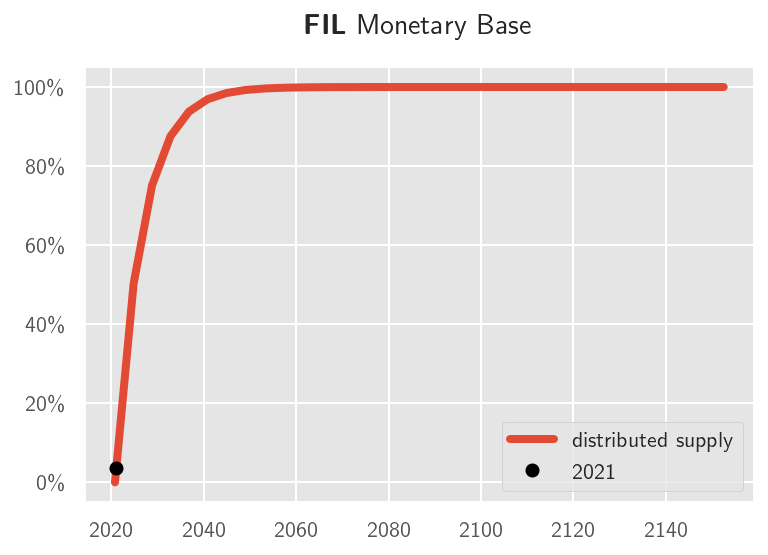

In [10]:
display(supply.head())
display(supply.tail())

cmb.plot_supply_curve(
    supply,
    COIN_SYMBOL,
);

## Standardize Time Series

In [11]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 6876 lines to file ../output-data/FIL_weekly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,577,28850.0,0.137381,2020-10-01
2,FIL,1585,79250.0,0.377381,2020-10-01
3,FIL,2593,129650.0,0.617381,2020-11-01
4,FIL,3601,180050.0,0.857381,2020-11-01


,coin,block,total_supply,total_supply_pct,date
6871,FIL,6925537,2.100000e+07,100.0,2152-06-01
6872,FIL,6926545,2.100000e+07,100.0,2152-06-01
6873,FIL,6927553,2.100000e+07,100.0,2152-07-01
6874,FIL,6928561,2.100000e+07,100.0,2152-07-01
6875,FIL,6929569,2.100000e+07,100.0,2152-07-01


In [12]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1582 lines to file ../output-data/FIL_monthly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,2449,122450.0,0.583095,2020-11-01
2,FIL,6769,338450.0,1.611667,2020-12-01
3,FIL,11233,561650.0,2.674524,2021-01-01
4,FIL,15697,784850.0,3.737381,2021-02-01


,coin,block,total_supply,total_supply_pct,date
1577,FIL,6909697,2.100000e+07,100.0,2152-03-01
1578,FIL,6914161,2.100000e+07,100.0,2152-04-01
1579,FIL,6918481,2.100000e+07,100.0,2152-05-01
1580,FIL,6922945,2.100000e+07,100.0,2152-06-01
1581,FIL,6927265,2.100000e+07,100.0,2152-07-01


In [13]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 133 lines to file ../output-data/FIL_yearly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,11233,561650.0,2.674524,2021-01-01
2,FIL,63793,3189650.0,15.188810,2022-01-01
3,FIL,116353,5817650.0,27.703095,2023-01-01
4,FIL,168913,8445650.0,40.217381,2024-01-01


,coin,block,total_supply,total_supply_pct,date
128,FIL,6690673,2.100000e+07,100.0,2148-01-01
129,FIL,6743377,2.100000e+07,100.0,2149-01-01
130,FIL,6795937,2.100000e+07,100.0,2150-01-01
131,FIL,6848497,2.100000e+07,100.0,2151-01-01
132,FIL,6901057,2.100000e+07,100.0,2152-01-01
